In [2]:
import random

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter

env = gym.make("Pong-v0")

NOOP = 0
UP_ACTION = 2
DOWN_ACTION = 3

_ = env.reset()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(),
                       T.Resize(80),
                       T.ToTensor()])

def preprocess(x):
#     screen = env.render(mode='rgb_array') # (H,W,C) = (216,160,3)
    x = x[35:195, :] # cut out the score and border
    return transform(x)


class PolicyNetwork(nn.Module):
    '''
    (N,1,80,80) -> (N,3) probability distribution of 3 actions
    '''
    def __init__(self, h, w, outputs):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=8, stride=2)
        self.conv2 = nn.Conv2d(3, 16, kernel_size=4, stride=2)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(w, 8, 2), 4, 2)
        convh = conv2d_size_out(conv2d_size_out(h, 8, 2), 4, 2)
        linear_input_size = 16 * convw * convh
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.head(x.view(x.size(0), -1))
    
model = PolicyNetwork(80, 80, 3)
optimizer = optim.RMSprop(model.parameters())


def select_action(x):
    x = x.unsqueeze(0)
    dist = Categorical(logits=model(x))
    sampled_action = dist.sample()
    log_p = dist.log_prob(sampled_action)
    sampled_action = sampled_action.item()
    if sampled_action == 0:
        return NOOP, log_p
    elif sampled_action == 1:
        return UP_ACTION, log_p
    elif sampled_action == 2:
        return DOWN_ACTION, log_p
    

render = True
batch_size = 10
gamma = 0.99


def discount_rewards(r):
    r = np.array(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        if r[t] != 0:
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [5]:
running_reward = None
reward_sum = 0
episode_number = 0

rewards_received = []
log_p_actions = []

observation = env.reset()
prev_x = preprocess(observation)
while True:
    if render:
        env.render()
    
    cur_x = preprocess(observation)
    x = cur_x - prev_x
    prev_x = cur_x
    
    action, log_p_action = select_action(x)
    
    log_p_actions.append(log_p_action)
    
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    
    rewards_received.append(reward)
    
    if done:
        episode_number += 1
        
        discounted_rewards = discount_rewards(rewards_received)
        
        loss = (discounted_rewards * log_p_actions).sum()
        loss.backward()
        
        
        if episode_number % batch_size == 0:
            optimizer.step()
            optimizer.zero_grad()
            
            epoch = epsiode_number // batch_size
            writer.add_scalar('Running Reward', running_reward, epoch)
            
        if running_reward is None:
            running_reward = reward_sum
        else:
            running_reward = 0.99 * running_reward + 0.01 * reward_sum
            
        rewards_received, log_p_actions = [], []
        reward_sum = 0
        observation = env.reset()
        prev_x = preprocess(observation)
        
        break
    

In [111]:
transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(),
                       T.Resize(80),
                       T.ToTensor()])

def preprocess(x):
#     screen = env.render(mode='rgb_array') # (H,W,C) = (216,160,3)
    x = x[35:195, :] # cut out the score and border
    return transform(screen)


In [99]:
class PolicyNetwork(nn.Module):
    '''
    (N,1,80,80) -> (N,3) probability distribution of 3 actions
    '''
    def __init__(self, h, w, outputs):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=8, stride=2)
        self.conv2 = nn.Conv2d(3, 16, kernel_size=4, stride=2)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(w, 8, 2), 4, 2)
        convh = conv2d_size_out(conv2d_size_out(h, 8, 2), 4, 2)
        linear_input_size = 16 * convw * convh
        self.head = nn.Linear(linear_input_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.head(x.view(x.size(0), -1))
        

In [177]:
model = PolicyNetwork(80, 80, 3)
optimizer = optim.RMSprop(model.parameters())


/Users/peter/miniconda3/envs/spinningup/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


(tensor([[ 0.2312,  0.0720, -0.1642]], grad_fn=<AddmmBackward>),
 tensor([[0.3958, 0.3376, 0.2666]], grad_fn=<SoftmaxBackward>))

In [3]:
_,a=select_action(torch.randn(1,80,80))
_,b=select_action(torch.randn(1,80,80))
([a,b] * np.array([12,51])).sum()

a

tensor([-1.0631], grad_fn=<SqueezeBackward1>)

In [239]:
def select_action(x):
    x = x.unsqueeze(0)
    dist = Categorical(logits=model(x))
    sampled_action = dist.sample()
    log_p = dist.log_prob(sampled_action)
    sampled_action = sampled_action.item()
    if sampled_action == 0:
        return NOOP, log_p
    elif sampled_action == 1:
        return UP_ACTION, log_p
    elif sampled_action == 2:
        return DOWN_ACTION, log_p
    
    

In [208]:
render = True
batch_size = 10
gamma = 0.99

In [179]:

running_reward = None
reward_sum = 0
episode_number = 0

rewards_received = []
log_p_actions = []

observation = env.reset()
prev_x = preprocess(observation)
while True:
    if render:
        env.render()
    
    cur_x = preprocess(observation)
    x = cur_x - prev_x
    prev_x = cur_x
    
    action, log_p_action = select_action(x)
    
    log_p_actions.append(log_p_action)
    
    observation, reward, done, info = env.step(action)
    reward_sum += reward
    
    rewards_received.append(reward)
    
    if done:
        episode_number += 1
        
        discounted_rewards = discount_rewards(rewards_received)
        
        loss = (discounted_rewards * log_p_actions).sum()
        loss.backward()
        
        
        if episode_number % batch_size == 0:
            optimizer.step()
            optimizer.zero_grad()
            
            epoch = epsiode_number // batch_size
            writer.add_scalar('Running Reward', running_reward, epoch)
            
        if running_reward is None:
            running_reward = reward_sum
        else:
            running_reward = 0.99 * running_reward + 0.01 * reward_sum
            
        rewards_received, log_p_actions = [], []
        reward_sum = 0
        observation = env.reset()
        prev_x = preprocess(observation)
        
        break
    

-1.0 1094


In [247]:
discount_rewards([0.0,0.0,1.0])

array([0.9801, 0.99  , 1.    ])

In [246]:
def discount_rewards(r):
    r = np.array(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        if r[t] != 0:
            running_add = 0
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [75]:
# Frame list collector
frames = []
STEPS = 300

# code for the two only actions in Pong
NOOP = 0
UP_ACTION = 2
DOWN_ACTION = 3

# initializing our environment
env = gym.make("Pong-v0")

# beginning of an episode
observation = env.reset()
observation.shape

(210, 160, 3)

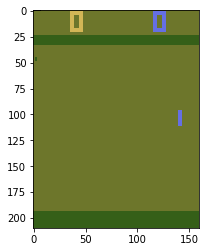

In [6]:
plt.imshow(observation)

In [110]:
# main loop
env.reset()
for i in range(STEPS):
    # choose random action
    env.render()
    action = random.randint(UP_ACTION, DOWN_ACTION)

    #run one step
    observation, reward, done, info = env.step(action)
    frames.append(observation) # collecting observation
    print(reward, done)

    # if episode is over, reset to beginning
    if done:
        observation = env.reset()
        frames.append(observation) # collecting observation

0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
-1.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False
0.0 False

In [109]:
reward

0.0

In [67]:

transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(),
                       T.Resize(80),
                       T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array') # (H,W,C) = (216,160,3)
    screen = screen[35:195, :] # cut out the score and border
    return transform(screen)


In [69]:
transform(screen).shape

torch.Size([1, 80, 80])

In [61]:
initial_height //2

80

In [24]:
import torch
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [25]:
Q = 3*a**3 - b**2


In [26]:
Q.sum().backward()

In [11]:
a.grad, b.grad

(tensor([36., 81.]), tensor([-12.,  -8.]))

In [12]:
lr = 0.001

In [16]:
a, b

(tensor([2., 3.], requires_grad=True), tensor([6., 4.], requires_grad=True))

In [19]:
ap = a - lr * a.grad

In [20]:
bp = b - lr * b.grad

In [21]:
3*ap**3 - bp**2

tensor([-13.4170,  58.5505], grad_fn=<SubBackward0>)

In [22]:
Q

tensor([-12.,  65.], grad_fn=<SubBackward0>)

In [27]:
Q.sum().backward()

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.